In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Preprocess data

In [2]:
# Import data
path = "../data/petdata_1000_100.csv"
raw_data = pd.read_csv(path, index_col="doc_uri")
assert raw_data.shape == (1000,100), "Import error, df has false shape"

#### Conversion and cleaning
Surprise forces you to use schema \["user_id", "doc_id", "rating"\]

CF models are often sensitive to NA values -> replace NaN with 0 (TBD: originally 0 codes to non-rating, but doc already shown to user)

In [3]:
# Convert df
data = raw_data.unstack().to_frame().reset_index()
data.columns = ["user", "doc_uri", "rating"]

# Missing value handling
data.fillna(0, inplace=True) 

assert data.shape == (raw_data.shape[0] * raw_data.shape[1], 3), "Conversion error, df has false shape"
assert data.rating.max() <= 5., "Value error, max rating over upper bound"
assert data.rating.min() >= 0., "Value error, min rating under lower bound"
data.head()

,user,doc_uri,rating
0,Aaron Keith III,http://www.vargas.biz/login.php,1.0
1,Aaron Keith III,http://wallace-walker.info/index/,1.0
2,Aaron Keith III,http://www.jimenez.biz/,3.0
3,Aaron Keith III,http://www.logan.com/about.html,0.0
4,Aaron Keith III,http://cox.org/list/tag/faq.html,5.0


### Descriptive statistics of ratings
Not meaningful <- randomly generated

In [4]:
data.rating.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
rating,100000.0,1.6925,1.826367,0.0,0.0,1.0,3.0,5.0


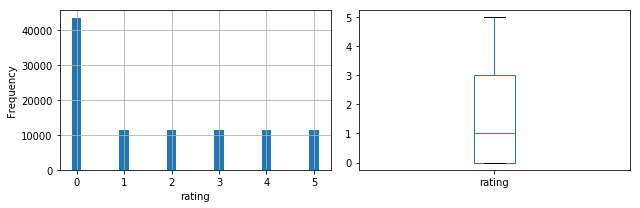

In [5]:
# Plot distribution of (random) ratings 

plt.rcParams['figure.figsize'] = [9, 3]

plt.subplot(1, 2, 1)
hist = data.rating.plot(kind="hist", grid=True,
                        bins=[-0.1,0.1,0.9,1.1,1.9,2.1,2.9,3.1,3.9,4.1,4.9,5.1])
hist.set(xlabel= "rating")

plt.subplot(1, 2, 2)
box = data.rating.plot(kind="box")

plt.tight_layout()
plt.savefig("plots/ratings.png", orientation="landscape", dpi=120)

# Recommendation Engines

## Model-based Collaborative Filtering

In [6]:
from surprise import SVD, Dataset, Reader, NMF, accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.random_pred import NormalPredictor

reader = Reader(rating_scale=(1, 5))
ds = Dataset.load_from_df(data[["user", "doc_uri", "rating"]], reader)

baseline_model = NormalPredictor() # Baseline model, predicts labels based on distribution of ratings

### Matrix factorization-based CF

In [7]:
# Models - tune parameters, if you'd like ;)
svd = SVD() # Singular Value Decomposition
nmf = NMF() # Non-negative Matrix factorization

#### Model Evaluation
Don't expect accurate models <- they are trained with random noise

In [8]:
for algo in [baseline_model, svd, nmf]:
    cross_validate(algo, ds, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.2390  2.2316  2.2146  2.2412  2.2386  2.2330  0.0097  
MAE (testset)     1.8609  1.8607  1.8439  1.8664  1.8672  1.8598  0.0084  
Fit time          0.08    0.12    0.08    0.07    0.07    0.08    0.02    
Test time         0.12    0.12    0.11    0.11    0.10    0.11    0.01    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9133  1.9143  1.9141  1.9208  1.9139  1.9153  0.0028  
MAE (testset)     1.6388  1.6390  1.6402  1.6455  1.6414  1.6410  0.0024  
Fit time          5.37    5.34    5.95    6.06    6.32    5.81    0.39    
Test time         0.13    0.15    0.13    0.14    0.13    0.13    0.01    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
R

### k-NN-based CF

In [9]:
from surprise.prediction_algorithms.knns import KNNBasic

sim_options = {"name": "pearson", # pearson's r
               "user_based": False  # item-based
               }

knn = KNNBasic(sim_options=sim_options)

#### Model Evaluation
Don't expect accurate models <- they are trained with random noise

In [10]:
cross_validate(knn, ds, measures=["RMSE", "MAE"], cv=5, verbose=True)

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7801  1.7824  1.7901  1.7829  1.7809  1.7833  0.0035  
MAE (testset)     1.5493  1.5491  1.5542  1.5501  1.5469  1.5499  0.0024  
Fit time          6.21    6.00    6.52    7.74    4.56    6.21    1.02    
Test time         15.85   13.38   15.52   14.39   16.20   15.07   1.04    


{'fit_time': (6.211174488067627,
  5.996851444244385,
  6.519110202789307,
  7.739609956741333,
  4.562095403671265),
 'test_mae': array([1.54929938, 1.54914995, 1.55422394, 1.55005547, 1.54685839]),
 'test_rmse': array([1.78010419, 1.78244229, 1.79006299, 1.78291537, 1.78085411]),
 'test_time': (15.854188680648804,
  13.37714147567749,
  15.522441864013672,
  14.388406753540039,
  16.198522567749023)}

## Final model and predictions
kNN Basic looks most promising so far, so go for this one

#### Train & evaluate final model

In [11]:
# Train final model
trainset = ds.build_full_trainset()
knn.fit(trainset)

# RMSE of final model
testset = trainset.build_testset()
test_pred = knn.test(testset)
accuracy.rmse(test_pred, verbose=True) # should be very bad ;)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3321


1.3321412404968649

#### Predict some document ratings

In [12]:
combinations_to_predict = [("Aaron Keith III", "http://gregory.com/"),
                           ("Abigail Wong", "http://hicks.com/"),
                           ("Julie Bullock", "https://www.garcia.com/"),
                           ("Victoria Perez", "http://lee-phillips.org/register/")]

In [13]:
# Predictions
for combination in combinations_to_predict:
    user = combination[0]
    doc = combination[1]
    pred = knn.predict(user, doc)
    print(pred[0], "should rate", pred[1], "with", int(round(pred[3])), "stars")

Aaron Keith III should rate http://gregory.com/ with 1 stars
Abigail Wong should rate http://hicks.com/ with 1 stars
Julie Bullock should rate https://www.garcia.com/ with 1 stars
Victoria Perez should rate http://lee-phillips.org/register/ with 2 stars
